# MICCoM School 2017 Ex#5 : Hybrid functionals

<p>We are going to use the SX hybrid functional in order to compute the VIP of silane.</p>
<p>A hybrid functional contains a mixture of semilocal ($V_{x}$) and exact exchange ($V_{xx}$): <br><br>
\begin{equation}
H^{hyb}= T + V_{ion} + V_{Hartree} + V_{xc} + \alpha (V_{xx}-V_{x})
\end{equation}<br>
For the hybrid functional PBE0 $\alpha=0.25$. <br>
A class of dielectric dependent hybrid functionals was developed in order to make $\alpha$ material dependent and to obtain higher accuracy. For dielectric dependent hybrid functionals $\alpha$ is a parameter that can be determined from first principles:
<ul>
<li>For solids (sc-hybrid functional): $\alpha = \epsilon_\infty^{-1}$ [<a href="https://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.195112">Phys. Rev. B 89, 195112 (2014)</a>]
<li>For molecules (SX functional): $\alpha_n = \frac{\left\langle \psi_n \right| \Sigma_{SEX} \left | \psi_n \right\rangle}{\left\langle \psi_n \right| \Sigma_{EX} \left | \psi_n \right\rangle} $ [<a href="https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.041002">Phys. Rev. X 6, 041002 (2016)</a>]
</ul>
where $\Sigma_{SEX}$ is the screened exact exchange and $\Sigma_{SX}$ is the exact exchange:<br><br>
\begin{equation}
\Sigma_{SEX}(\mathbf{r},\mathbf{r^\prime}) = -\sum_n^{states} \psi_n(\mathbf{r}) W(\mathbf{r},\mathbf{r^\prime}) \psi^\ast_n(\mathbf{r^\prime})
\end{equation}
and
\begin{equation}
\Sigma_{EX}(\mathbf{r},\mathbf{r^\prime}) = -\sum_n^{states} \psi_n(\mathbf{r}) v_{Coulomb}(\mathbf{r},\mathbf{r^\prime}) \psi^\ast_n(\mathbf{r^\prime})
\end{equation}<br>
</p>

In order to compute the SX constant we need to compute the DFT electronic structure with semilocal functionals (`pw.x`), compute the eigendecomposition of the dielectric screening (`wstat.x`), and extract the information about the screening with the WEST post-processing (`westpp.x`).

Let's download the material.

In [1]:
# pseudopotentials
!wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/Si_ONCV_PBE-1.2.upf
!wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/H_ONCV_PBE-1.2.upf

# input files
!wget -N -q http://www.west-code.org/doc/training/silane/pw.in
!wget -N -q http://www.west-code.org/doc/training/silane/wstat.in
!wget -N -q http://www.west-code.org/doc/training/silane/westpp.in

<p>These two steps may be familiar:</p>

In [ ]:
!mpirun -n 8 pw.x -i pw.in > pw.out

In [ ]:
!mpirun -n 8 wstat.x -i wstat.in > wstat.out

## 5.1 The SX constant
The calculation of the SX constant is done using `westpp.x`.

<p>Let's give a quick look at the input for <tt><b>westpp.x</b></tt> (description of the input variables for <tt><b>westpp.x</b></tt> can be found here: http://www.west-code.org/doc/West/latest/manual.html#westpp-control)</p>

In [2]:
# quick look at the input file for westpp.x
!cat westpp.in

input_west:
    qe_prefix: silane
    west_prefix: silane
    outdir: ./

wstat_control:
    wstat_calculation: S
    n_pdep_eigen: 50

westpp_control:
    westpp_calculation: S
    westpp_n_pdep_eigen_to_use: 50
    westpp_range: [1,4]

The input instructs the code to read the output of DFT and 50 eigenpotentials (previously computed using `wstat.x`), then extract the values of $\left\langle \psi_n \right| \Sigma_{EX} \left | \psi_n \right\rangle$ and $\left\langle \psi_n \right| \Sigma_{SEX} \left | \psi_n \right\rangle$ for states 1, 2, 3, and 4.

In [ ]:
!mpirun -n 8 westpp.x -i westpp.in > westpp.out

For HOMO $\alpha=0.758899$, let's use it to perform a hybrid DFT calculation.

Note the addition of:

<code>
input_dft       ='PBE0'
exx_fraction    = 0.758899
</code>

in the input file for `pw.x`.

In [3]:
# write to file
with open('pw_hybrid.in', 'w') as text_file :
    text_file.write("""&control
calculation  = 'scf'
restart_mode = 'from_scratch'
pseudo_dir   = './'
outdir       = './'
prefix       = 'silane'
wf_collect   = .TRUE.
/
&system
ibrav           = 1
celldm(1)       = 20
nat             = 5
ntyp            = 2
ecutwfc         = 25.0
nbnd            = 10
assume_isolated ='mp'
input_dft       ='PBE0'
exx_fraction    = 0.758899
/
&electrons
diago_full_acc = .TRUE.
/
ATOMIC_SPECIES
Si 28.0855  Si_ONCV_PBE-1.2.upf
H  1.00794   H_ONCV_PBE-1.2.upf
ATOMIC_POSITIONS bohr
Si      10.000000   10.000000  10.000000
H       11.614581   11.614581  11.614581
H        8.385418    8.385418  11.614581
H        8.385418   11.614581   8.385418
H       11.614581    8.385418   8.385418
K_POINTS {gamma}
""")

In [ ]:
!mpirun -n 8 pw.x -i pw_hybrid.in > pw_hybrid.out

<p>We plot the energy levels.</p>

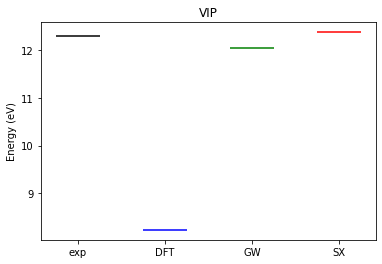

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# VIP
y = {}
y['exp'] = [ 12.3 ]
y['DFT'] = [ 8.2314 ]
y['GW']  = [ 12.044023 ]
y['SX']  = [ 12.3729 ]

# colors
c = {}
c['exp'] = 'black'
c['DFT'] = 'blue'
c['GW']  = 'green'
c['SX']  = 'red'

# plot
x = list( range( 1, len(y)+1 ) )
labels = y.keys()

fig, ax = plt.subplots(1, 1)
counter = 0
for i in labels :
    for a in y[i] :
        ax.hlines(a, x[counter]-0.25, x[counter]+0.25, color=c[i])
    counter += 1

plt.xticks(x, labels)

plt.ylabel('Energy (eV)')
plt.title('VIP')

plt.show()